# Causal Influence Decomposition of the Human Brain Using Multi-site In-silico Perturbation Analysis


In [1]:
%load_ext autoreload
%autoreload 2

##  we're using the following packages (see requirements.txt for more):

#   msapy == 1.1.0
#   netneurotools 0.2.3
#   numpy == 1.20.3
#   numba == 0.56.4
#   pandas == 1.3.5 ## make sure it's not 1.5 otherwise somehow the causal influence matrices shift and we still don't know why because the tests all pass with both versions!
#   bctpy == 0.6.0
#   networkx == 3.0

In [2]:
import numpy as np
from msapy import msa, plottings as pl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import networkx as nx
import seaborn as sns
import utils as ut
import pandas as pd
from netneurotools.metrics import communicability_wei, communicability_bin, distance_wei_floyd
from scipy.stats import pearsonr
import warnings
from sklearn.preprocessing import StandardScaler
import scipy

In [3]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED = '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

sagittal=(0, 180)
axial=(90, 180)
coronal=(0, 90)
bottom=(-90,0)

In [4]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6,nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0,5]=1
closedchain = ut.spectral_normalization(0.9,closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = ut.spectral_normalization(0.9,symmetricchain)

timesteps = 100
example_input = ut.event_maker(6,timesteps)


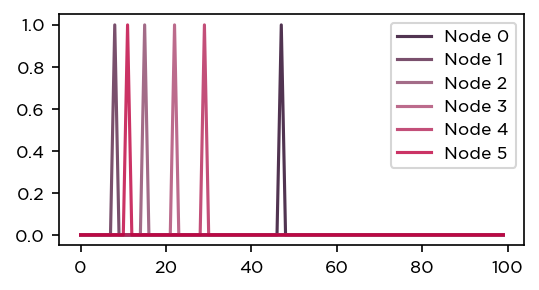

In [5]:
plt.figure(figsize=(4,2),dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(example_input.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5']);

In [6]:
NOISE_STRENGTH = 0.05
DELTA = 0.01
TAU = 0.02
G =0.74
DURATION = 1
model_params = {'dt':DELTA,'timeconstant':TAU,'coupling':G,'duration':DURATION}

In [7]:
warnings.filterwarnings("ignore")

simple_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=chain,
                                                              input_matrix=example_input,
                                                                 **model_params)
closed_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=closedchain,
                                                              input_matrix=example_input,
                                                                 **model_params)
symmetric_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=symmetricchain,
                                                                 input_matrix=example_input,
                                                                 **model_params)

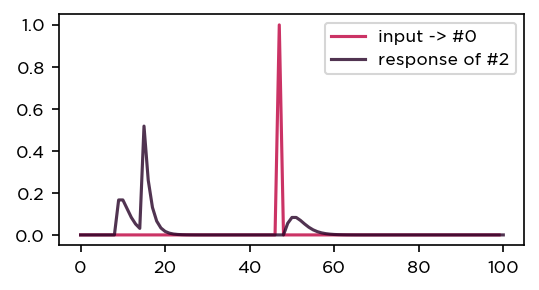

In [8]:
plt.figure(figsize=(4,2),dpi=150)

plt.plot(example_input[0],alpha=0.8,color=RED)
plt.plot(simple_chain_dynamics[2],alpha=0.8,color=PURPLEST)

plt.legend(['input -> #0','response of #2']);


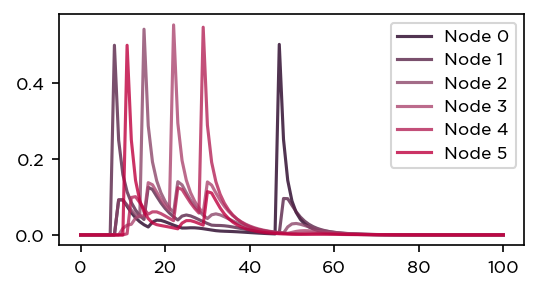

In [9]:
plt.figure(figsize=(4,2),dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(symmetric_chain_dynamics.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5'])

In [10]:
cchain = communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain = communicability_wei(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain = communicability_wei(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0


In [11]:
lesion_params = {'adjacency_matrix': chain, 'input': example_input, 'model_kwargs': model_params}
ci_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = closedchain
ci_closed_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)



0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 50.83it/s]
1it [00:00,  1.45it/s]

working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 12164.01it/s]


working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 10843.25it/s]
3it [00:00,  4.27it/s]

working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 11891.36it/s]


working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 11249.50it/s]
5it [00:00,  6.71it/s]

working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 11482.40it/s]
6it [00:01,  5.66it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 52.62it/s]
1it [00:00,  1.44it/s]

working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 13640.01it/s]


working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 3700.92it/s]
3it [00:00,  4.07it/s]

working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 4214.98it/s]
4it [00:00,  5.07it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 10096.11it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 12549.58it/s]
6it [00:01,  5.35it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 3243.93it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 3568.48it/s]
2it [00:00, 11.15it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 10784.87it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 4108.29it/s]
4it [00:00, 12.17it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 14928.01it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 13140.56it/s]
6it [00:00, 12.77it/s]


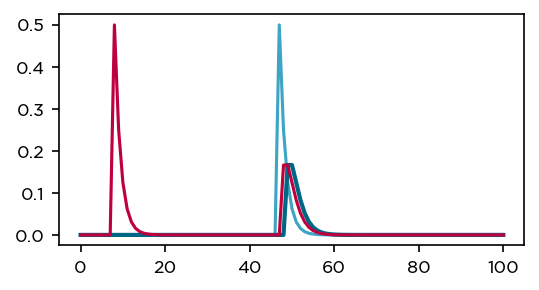

In [12]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(simple_chain_dynamics[0],color=BLUE)
plt.plot(ci_chain[0][1],color=DEEP_BLUE,linewidth=2) #influence of 0 on 1
plt.plot(simple_chain_dynamics[1],color=RED);

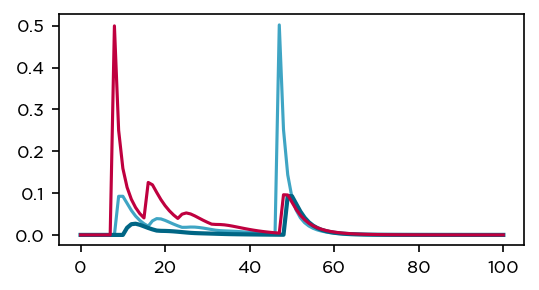

In [13]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(symmetric_chain_dynamics[0],color=BLUE)
plt.plot(ci_symmetric_chain[0][1],color=DEEP_BLUE,linewidth=2) #influence of 0 on 1
plt.plot(symmetric_chain_dynamics[1],color=RED);

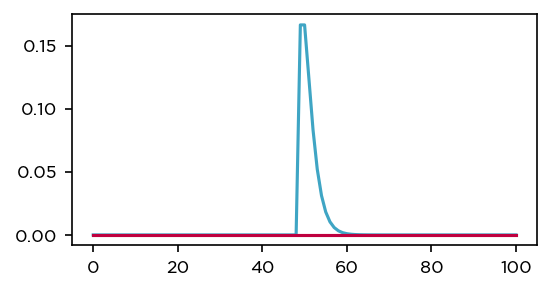

In [14]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(ci_chain[0][1],color=BLUE) #influence of 0 on 1
plt.plot(ci_chain[1][0],color=RED); #influence of 1 on 0

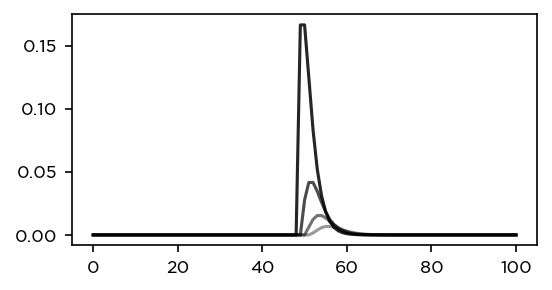

In [15]:
plt.figure(figsize=(4,2),dpi=150)
for i in range(5):
    plt.plot(ci_chain[0][i],color='k',alpha=1-i*0.15) #influence of 0 over the rest


In [16]:
example_modes = ci_symmetric_chain.values.reshape(6,101,6)

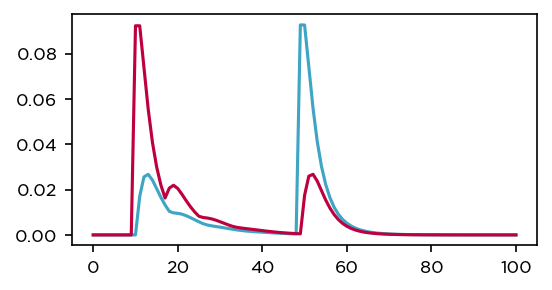

In [17]:
plt.figure(figsize=(4,2),dpi=150)

plt.plot(example_modes[1,:,0],color=BLUE) #influence of 0 on 1
plt.plot(example_modes[0,:,1],color=RED); #influence of 1 on 0

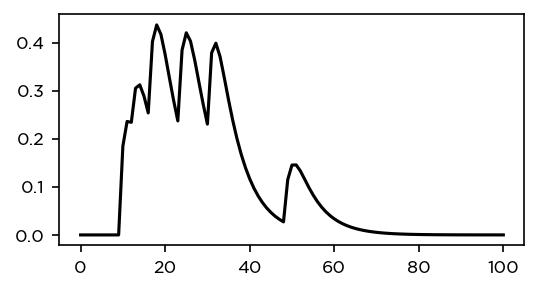

In [18]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(np.nan_to_num(example_modes).sum(axis=0).sum(axis=1),color='k');

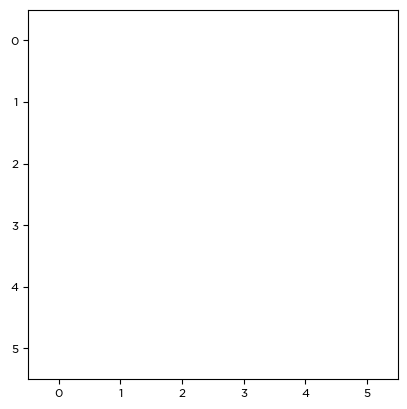

In [19]:
fig, ax = plt.subplots()
heatmaps = [[plt.imshow(example_modes[:,i,:],cmap=white_red_mono,animated=True,vmin=0, vmax=np.nan_to_num(example_modes).max())] for i in range(101)]
anim = animation.ArtistAnimation(fig, heatmaps, interval=60,blit=True)
HTML(anim.to_jshtml())


In [20]:
# f = r"example_causal_contributions.gif" 
# writergif = animation.PillowWriter(fps=30) 
# anim.save(f, writer=writergif)

In [21]:
ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

In [22]:
chain_mask = np.where(cchain!=0,1,0)
closedchain_mask = np.where(ccchain!=0,1,0)
symmetricchain_mask = np.where(csychain!=0,1,0)

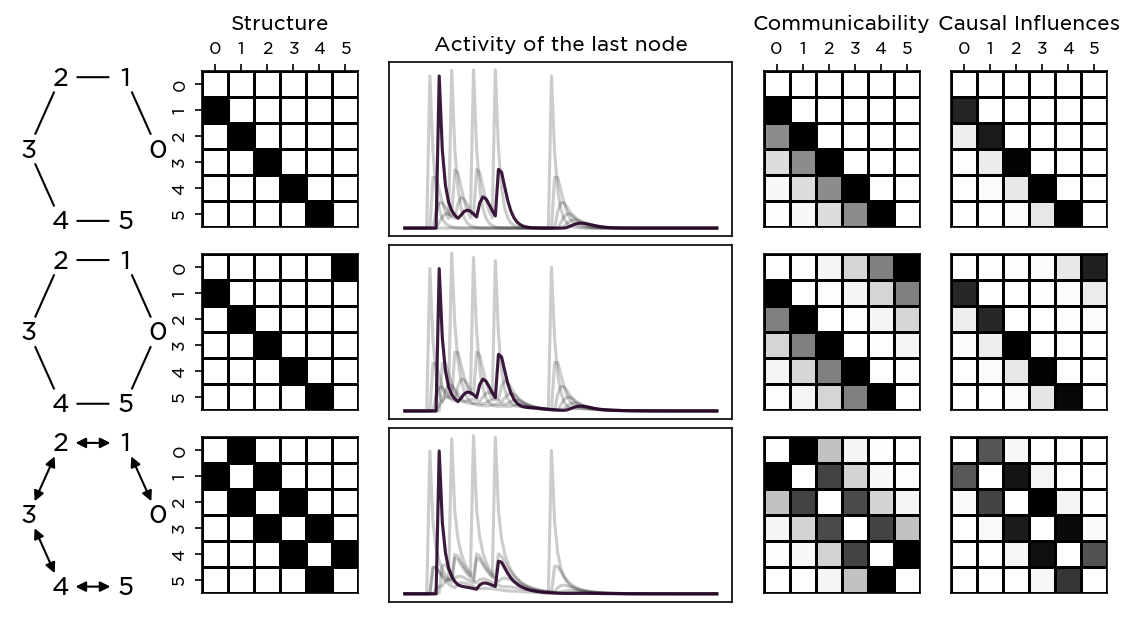

In [23]:
fig,axes = plt.subplot_mosaic([['A','X','B', 'B','CX','CIX'],
                               ['C','Y','D', 'D','CY','CIY'],
                               ['E','Z','F', 'F','CZ','CIZ']],figsize=(7.3,4),dpi=150)

#===================================== STRUCTURE
sns.heatmap(chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['X'],linewidths=0.5, linecolor='k')

sns.heatmap(closedchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Y'],linewidths=0.5, linecolor='k')

sns.heatmap(symmetricchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Z'],linewidths=0.5, linecolor='k')
#===================================== COMMUNICABILITY
sns.heatmap(cchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CX'],linewidths=0.5, linecolor='k')

sns.heatmap(ccchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CY'],linewidths=0.5, linecolor='k')

sns.heatmap(csychain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CZ'],linewidths=0.5, linecolor='k')
#===================================== CAUSAL INFLUENCE
sns.heatmap(ci_chain*chain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIX'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_closed_chain*closedchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIY'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_symmetric_chain*symmetricchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIZ'],linewidths=0.5, linecolor='k')


node_colors=[WHITE,WHITE,WHITE,WHITE,WHITE,WHITE]
nx.draw_circular(nx.from_numpy_array(chain),ax=axes['A'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(closedchain),ax=axes['C'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(symmetricchain),ax=axes['E'],
                 arrows=True,node_size=200,node_color=node_colors,arrowstyle='<|-|>',with_labels=True)
for ax in ['B','D','F']:

    axes[ax].yaxis.set_visible(False)

for ax in ['B','C','D','Y','Z']:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain)-1:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain)-1:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
        if i < len(chain)-1:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c='k',alpha=0.2)
        else:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

axes['B'].title.set_text('Activity of the last node')
axes['X'].title.set_text('Structure')
axes['CX'].title.set_text('Communicability')
axes['CIX'].title.set_text('Causal Influences')

axes['B'].yaxis.tick_right()

for ax in ['X','CX','CIX']:
    axes[ax].xaxis.tick_top()
for ax in ['CY','CZ','CIY','CIZ','F']:
    axes[ax].xaxis.set_visible(False)

for ax in ['CX','CY','CZ','CIX','CIY','CIZ']:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.1)

#plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [24]:
consensus_mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][2][0])
coordinates = consensus_mat['LauConsensus']['Matrices'][2][3]
labels = consensus_mat['LauConsensus']['Matrices'][2][4][:,0]

In [25]:
ut.check_symmetric(connectivity)

True

In [26]:
N_NODES = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity)!=0,1,0)

In [27]:
rng = np.random.default_rng(seed=SEED)
input_noise = rng.normal(0, NOISE_STRENGTH, (N_NODES, int(DURATION/DELTA)+1))

simple_human_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                                              input_matrix=input_noise,
                                                              **model_params)

<AxesSubplot:>

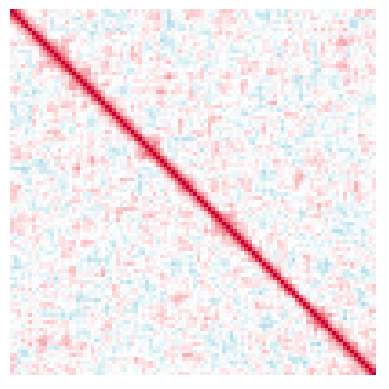

In [28]:
sns.heatmap(np.corrcoef(simple_human_dynamics.T),square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,cbar=False,linewidths=0,center=0, linecolor='k')

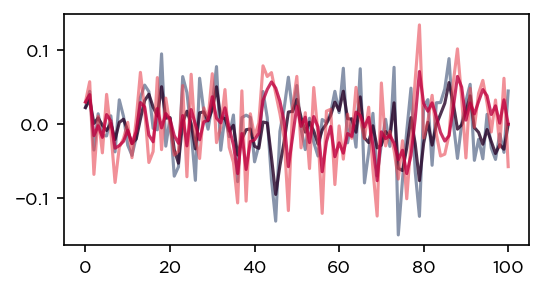

In [29]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(input_noise[-1],alpha=0.6,color=NIGHT_BLUE)
plt.plot(simple_human_dynamics[-1],alpha=0.8,color=PURPLEST)
plt.plot(input_noise[0],alpha=0.6,color=ORANGE)
plt.plot(simple_human_dynamics[0],alpha=0.8,color=RED);
#plt.savefig(f"example_activity.pdf",dpi=600,bbox_inches='tight')

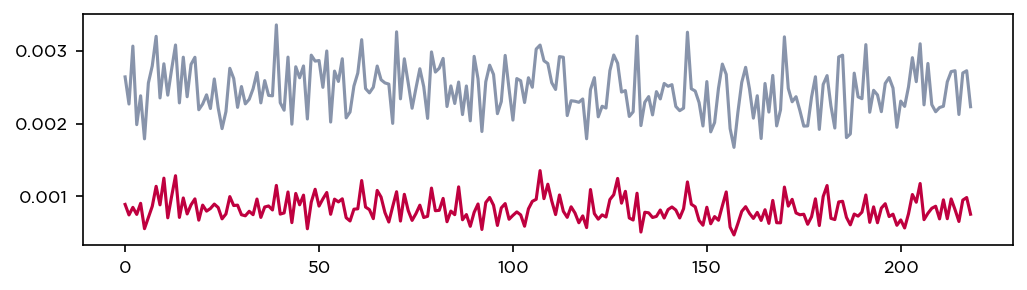

In [30]:
plt.figure(figsize=(8,2),dpi=150)
plt.plot(simple_human_dynamics.var(axis=1),color = RED)
plt.plot(input_noise.var(axis=1),alpha=0.6,color=NIGHT_BLUE);
#plt.xticks(np.arange(0,len(connectivity),1),rotation=90,fontsize=3);

In [31]:
input_output_similarity = []
for node in range(len(simple_human_dynamics)):
    input_output_similarity.append(pearsonr(simple_human_dynamics[node],input_noise[node])[0])

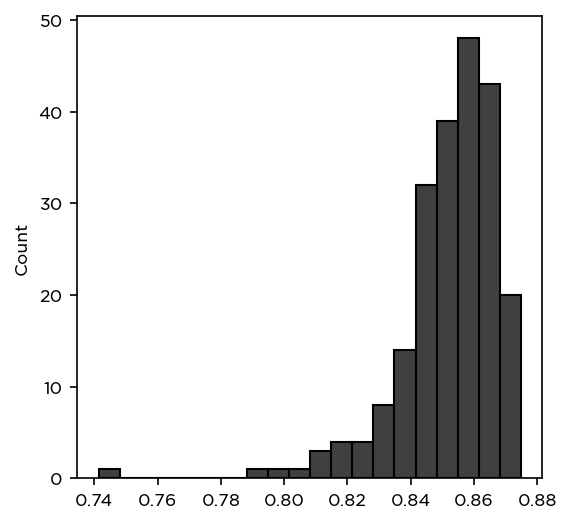

In [32]:
plt.figure(figsize=(4,4),dpi=150)
sns.histplot(input_output_similarity,bins=20,color='k');

<AxesSubplot:>

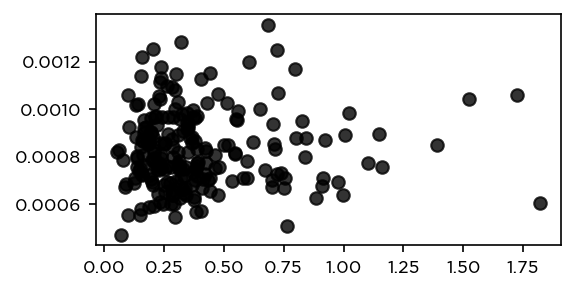

In [33]:
plt.figure(figsize=(4,2),dpi=150)
sns.regplot(connectivity.sum(axis=0),simple_human_dynamics.var(axis=1),color='k',fit_reg=False)

In [34]:
N_TRIALS = 10
all_trials = np.zeros((len(connectivity),len(connectivity),N_TRIALS))

In [35]:
for trial in range(N_TRIALS):
    temp = pd.read_pickle(f'results/causal_modes_l_w_{len(connectivity)}_{trial}.pickle').groupby(level=0).std().fillna(0)
    all_trials[:,:,trial] = temp

In [36]:
averaged_ci = all_trials.mean(axis=2)
averaged_ci = pd.DataFrame(averaged_ci)

In [37]:
ut.check_symmetric(averaged_ci)

False

In [38]:
lognorm_ci = ut.minmax_normalize(ut.log_normalize(averaged_ci))
np.fill_diagonal(lognorm_ci,0.)

lognorm_comm = ut.minmax_normalize(ut.log_normalize(communicability_wei(connectivity)))
np.fill_diagonal(lognorm_comm,0.)

lognorm_sc = ut.minmax_normalize(ut.log_normalize(connectivity))
np.fill_diagonal(lognorm_sc,0.)
lognorm_sc = np.where(lognorm_sc!=1,lognorm_sc,0)
difference = lognorm_ci-lognorm_comm

scaler = StandardScaler()
difference = scaler.fit_transform(difference)
np.fill_diagonal(difference,0.)

difference_outgoing = ut.make_influence_ratio(difference,axis=0)
difference_incoming = ut.make_influence_ratio(difference,axis=1)

difference_direct = pd.DataFrame(difference).where(connectivity!=0)
difference_indirect = pd.DataFrame(difference).where(connectivity==0)

direct_influence = pd.DataFrame(lognorm_ci).where(connectivity!=0)
indirect_influence = pd.DataFrame(lognorm_ci).where(connectivity==0)

<AxesSubplot:>

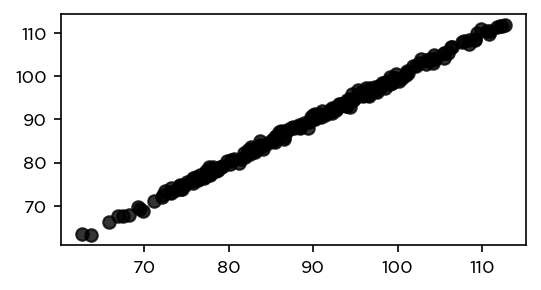

In [39]:
plt.figure(figsize=(4,2),dpi=150)
sns.regplot(lognorm_ci.sum(axis=0),lognorm_ci.sum(axis=1),fit_reg=False,color='k')

<AxesSubplot:ylabel='Count'>

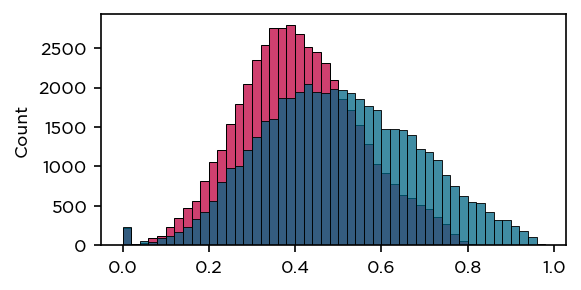

In [40]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(lognorm_ci.flatten(),binwidth=0.02,color=RED)
sns.histplot(lognorm_comm.flatten(),binwidth=0.02,color=DEEP_BLUE)


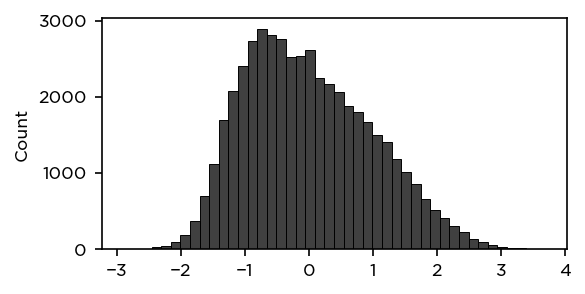

In [41]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(difference.flatten(),binwidth=0.15,color='k');

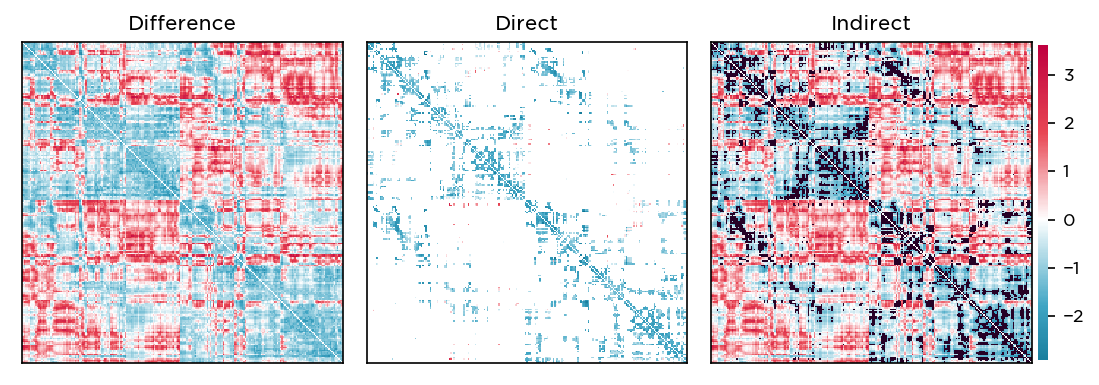

In [42]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
cbar_ax = fig.add_axes([.99, .2, .01, .6])

sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,cbar=False,ax=axes['A'],linewidths=0,center=0, linecolor='k')

sns.heatmap(difference_direct,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=diverge_from_white,cbar=False,ax=axes['B'],linewidths=0,linecolor='k')

sns.heatmap(difference_indirect,square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, center=0, linecolor='k')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Difference')
axes['B'].title.set_text('Direct')
axes['C'].title.set_text('Indirect')
axes['C'].set_facecolor(PURPLEST)
fig.tight_layout(pad=1)

In [43]:
geodesic_distance = -np.log10(connectivity.copy(order='C')/np.max(connectivity))
shortest_path_distance,_ = distance_wei_floyd(np.abs(geodesic_distance))

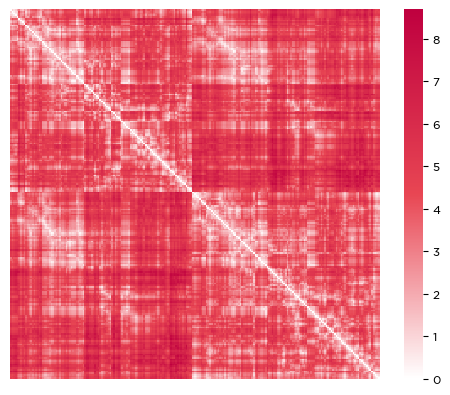

In [44]:
sns.heatmap(shortest_path_distance,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar=True,linewidths=0,linecolor='k');

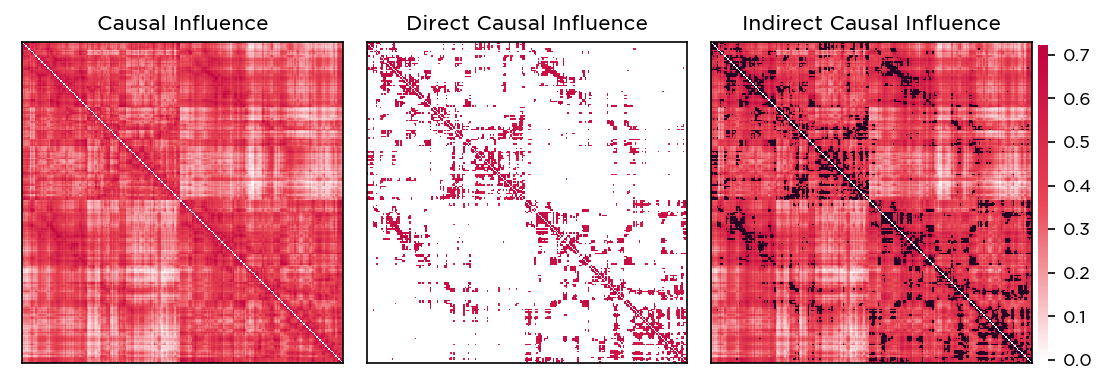

In [45]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
cbar_ax = fig.add_axes([.99, .2, .01, .6])

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['A'],linewidths=0, linecolor='k')

sns.heatmap(direct_influence,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=white_red_mono,cbar=False,ax=axes['B'],linewidths=0,linecolor='k')

sns.heatmap(indirect_influence,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, linecolor='k')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Causal Influence')
axes['B'].title.set_text('Direct Causal Influence')
axes['C'].title.set_text('Indirect Causal Influence')
axes['C'].set_facecolor(PURPLEST)
fig.tight_layout(pad=1)
#plt.savefig(f"causal_influences.pdf",dpi=600,bbox_inches='tight')

In [127]:
indirect_influence.fillna(0,inplace=True)
direct_influence.fillna(0,inplace=True)

indirect_sender_receiver_ratio = pd.DataFrame(data=np.array(indirect_influence.sum(axis=0)/indirect_influence.sum(axis=1)),index=labels)
direct_sender_receiver_ratio = pd.DataFrame(data=np.array(direct_influence.sum(axis=0)/direct_influence.sum(axis=1)),index=labels)

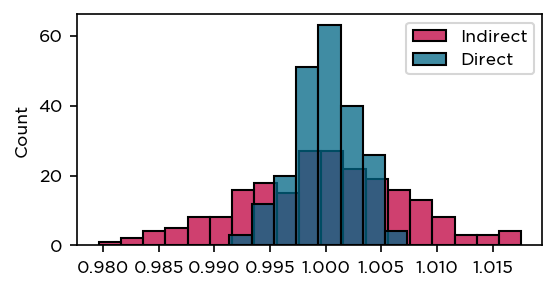

In [137]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(indirect_sender_receiver_ratio.values.flatten(),binwidth=0.002,color=RED,label = 'Indirect')
sns.histplot(direct_sender_receiver_ratio.values.flatten(),binwidth=0.002,color=DEEP_BLUE,label = 'Direct')
plt.legend()

In [119]:
indirect_sender_receiver_ratio.sort_values(0,ascending=False).head(10)

0
medialorbitofrontal   1.016963
precentral            1.016403
postcentral           1.015796
postcentral           1.015688
postcentral           1.014474
superiorfrontal       1.014093
lateralorbitofrontal  1.013769
paracentral           1.013240
precuneus             1.013157
paracentral           1.012969

In [120]:
indirect_sender_receiver_ratio.sort_values(0,ascending=True).head(10)

0
superiortemporal  0.979582
bankssts          0.982441
precuneus         0.982649
parstriangularis  0.984006
inferiorparietal  0.984714
bankssts          0.984725
lateraloccipital  0.985292
inferiortemporal  0.986037
lateraloccipital  0.986295
postcentral       0.986401

In [ ]:
scatter_kw = dict(alpha=1,linewidths=0.7,edgecolors='k')
size=80

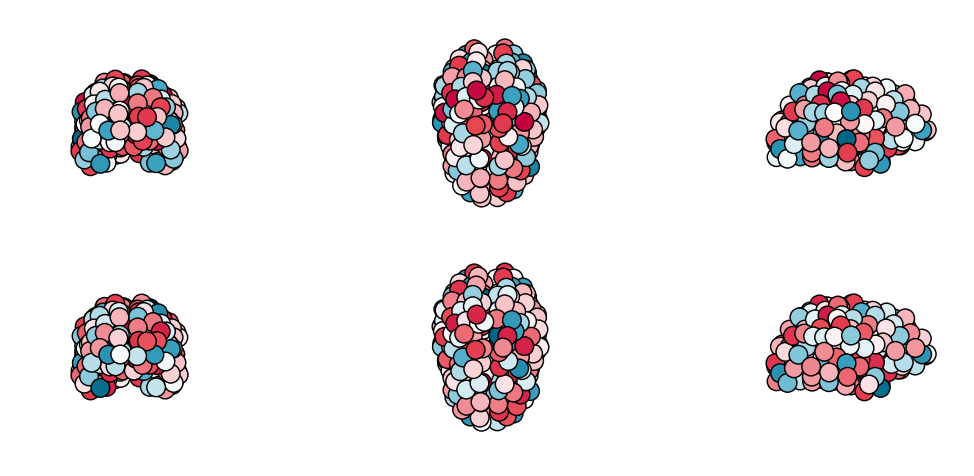

In [141]:
fig,axes = plt.subplot_mosaic([['A','B','C'],['D','E','F']],figsize=(8,3),subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['A'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['B'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['C'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)

ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['D'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['E'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['F'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=0.1)

<AxesSubplot:xlabel='0', ylabel='0'>

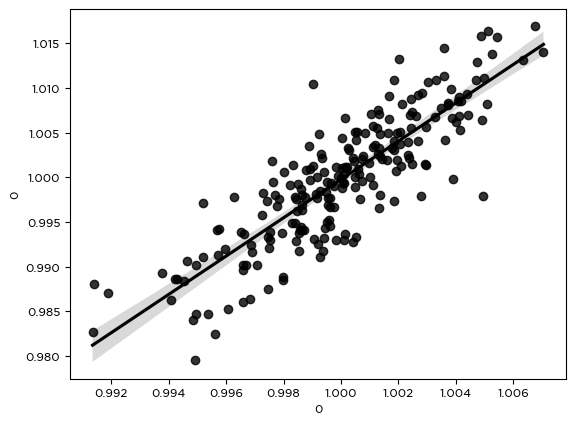

In [142]:
sns.regplot(direct_sender_receiver_ratio,indirect_sender_receiver_ratio,fit_reg=True,color='k')

<AxesSubplot:xlabel='0'>

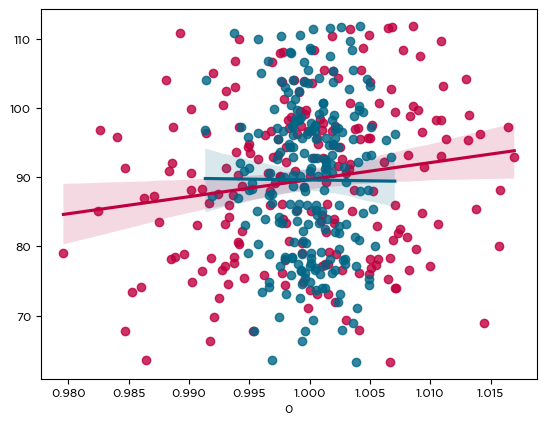

In [151]:
sns.regplot(indirect_sender_receiver_ratio,lognorm_ci.sum(1),fit_reg=True,color=RED)
sns.regplot(direct_sender_receiver_ratio,lognorm_ci.sum(1),fit_reg=True,color=DEEP_BLUE)

<AxesSubplot:xlabel='0'>

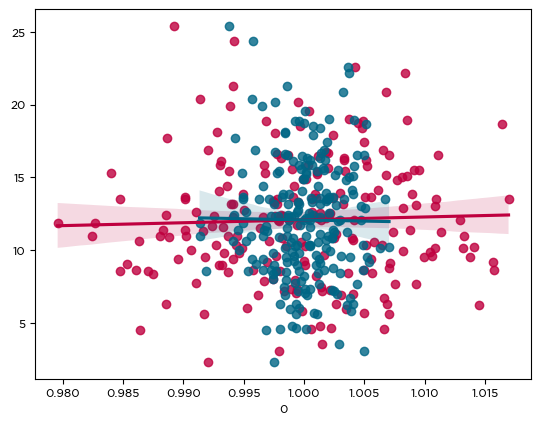

In [152]:
sns.regplot(indirect_sender_receiver_ratio,lognorm_sc.sum(1),fit_reg=True,color=RED)
sns.regplot(direct_sender_receiver_ratio,lognorm_sc.sum(1),fit_reg=True,color=DEEP_BLUE)

In [46]:
influence_gradient = pd.DataFrame(ut.minmax_normalize(ut.threshold(5,indirect_influence).sum(0).values),index=labels)

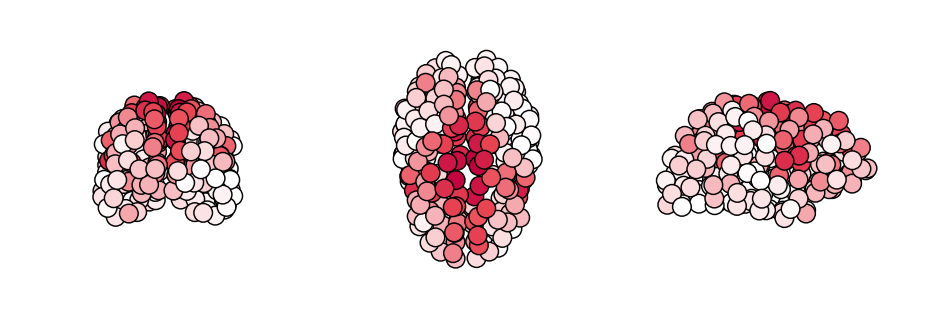

In [47]:

fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(6,2),subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(influence_gradient,coordinates,axes['A'],view=sagittal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['B'],view=axial,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['C'],view=coronal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)

fig.tight_layout(pad=0.1)
#plt.savefig(f"causal_gradient.pdf",dpi=600,bbox_inches='tight')

In [48]:
influence_gradient.sort_values(0,ascending=False).head(10)

0
superiorfrontal           1.000000
posteriorcingulate        0.989598
superiorfrontal           0.957347
superiorfrontal           0.892925
caudalanteriorcingulate   0.854730
superiorfrontal           0.844309
superiorfrontal           0.832810
paracentral               0.817338
paracentral               0.810961
parsopercularis           0.787934
superiorfrontal           0.775661
posteriorcingulate        0.721055
paracentral               0.712032
posteriorcingulate        0.711185
parsopercularis           0.672774
precentral                0.668082
superiorfrontal           0.659871
paracentral               0.594107
caudalanteriorcingulate   0.593958
caudalmiddlefrontal       0.581464
insula                    0.578226
posteriorcingulate        0.573495
precentral                0.555791
paracentral               0.552884
isthmuscingulate          0.541365
precentral                0.537974
superiorfrontal           0.537280
superiorfrontal           0.534018
superiorfrontal           0.528973
precuneus                 0.524775
precentral                0.513285
superiorfrontal           0.505145
rostralanteriorcingulate  0.488625
superiorfrontal           0.485305
superiorfrontal           0.467557
superiorfrontal           0.466949
parsopercularis           0.453639
superiorfrontal           0.443587
isthmuscingulate          0.427483
precentral                0.425850
insula                    0.419572
precuneus                 0.418242
precentral                0.415327
precentral                0.410077
superiorfrontal           0.401899
caudalmiddlefrontal       0.391155
caudalmiddlefrontal       0.388191
precuneus                 0.370702
rostralanteriorcingulate  0.365203
inferiorparietal          0.346196

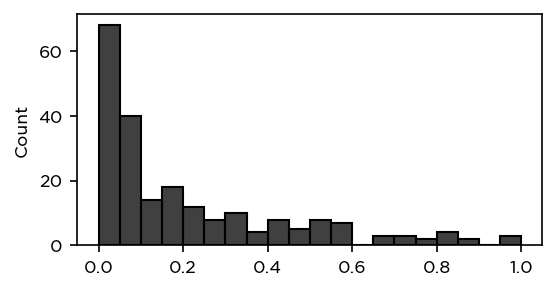

In [49]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(influence_gradient.values.flatten(),binwidth=0.05,color='k');

In [50]:
# warnings.filterwarnings("ignore")


# lesion_params = {'adjacency_matrix': connectivity, 'input': input_noise, 'model_kwargs': model_params}

# ci_mat = msa.estimate_causal_influences(elements=list(range(N_NODES)),
#                                         objective_function=ut.lesion_simple_nodes,
#                                         objective_function_params=lesion_params,
#                                         n_permutations=1_000, 
#                                         n_cores=-1,
#                                         parallelize_over_games=True,
#                                         permutation_seed=SEED)

# causal_influences = ci_mat.groupby(level=0).var().fillna(0)


In [51]:
# plt.figure(dpi=150)
# for i in range(n_neurons):
#     plt.plot(ci_mat[i][2],'k',alpha=0.3) # influence on the node
#     plt.plot(ci_mat[2][i],'r',alpha=0.3) # influenced by the node

<AxesSubplot:>

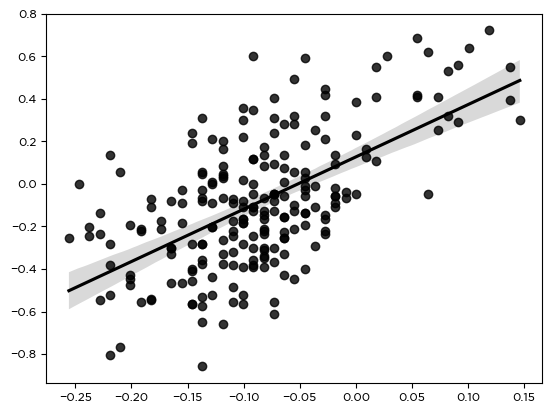

In [52]:
sns.regplot(difference_outgoing,difference_incoming,fit_reg=True,color='k')

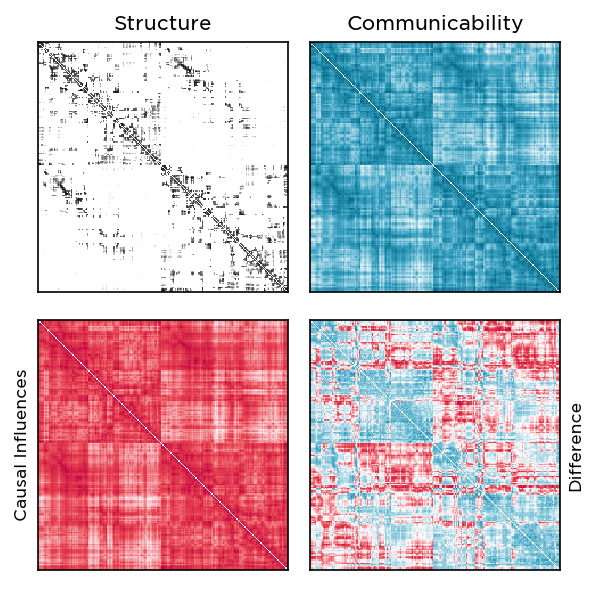

In [53]:
fig,axes = plt.subplot_mosaic([['A','CA'],
                               ['CI','DI']],figsize=(4,4),dpi=150)

sns.heatmap(lognorm_sc,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(lognorm_comm,square=True,xticklabels=False,yticklabels=False,
            cmap=white_blue_mono,cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=diverge_from_white,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['CI'].set_ylabel("Causal Influences")
axes['DI'].set_ylabel("Difference")
axes['DI'].yaxis.set_label_position("right")
fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

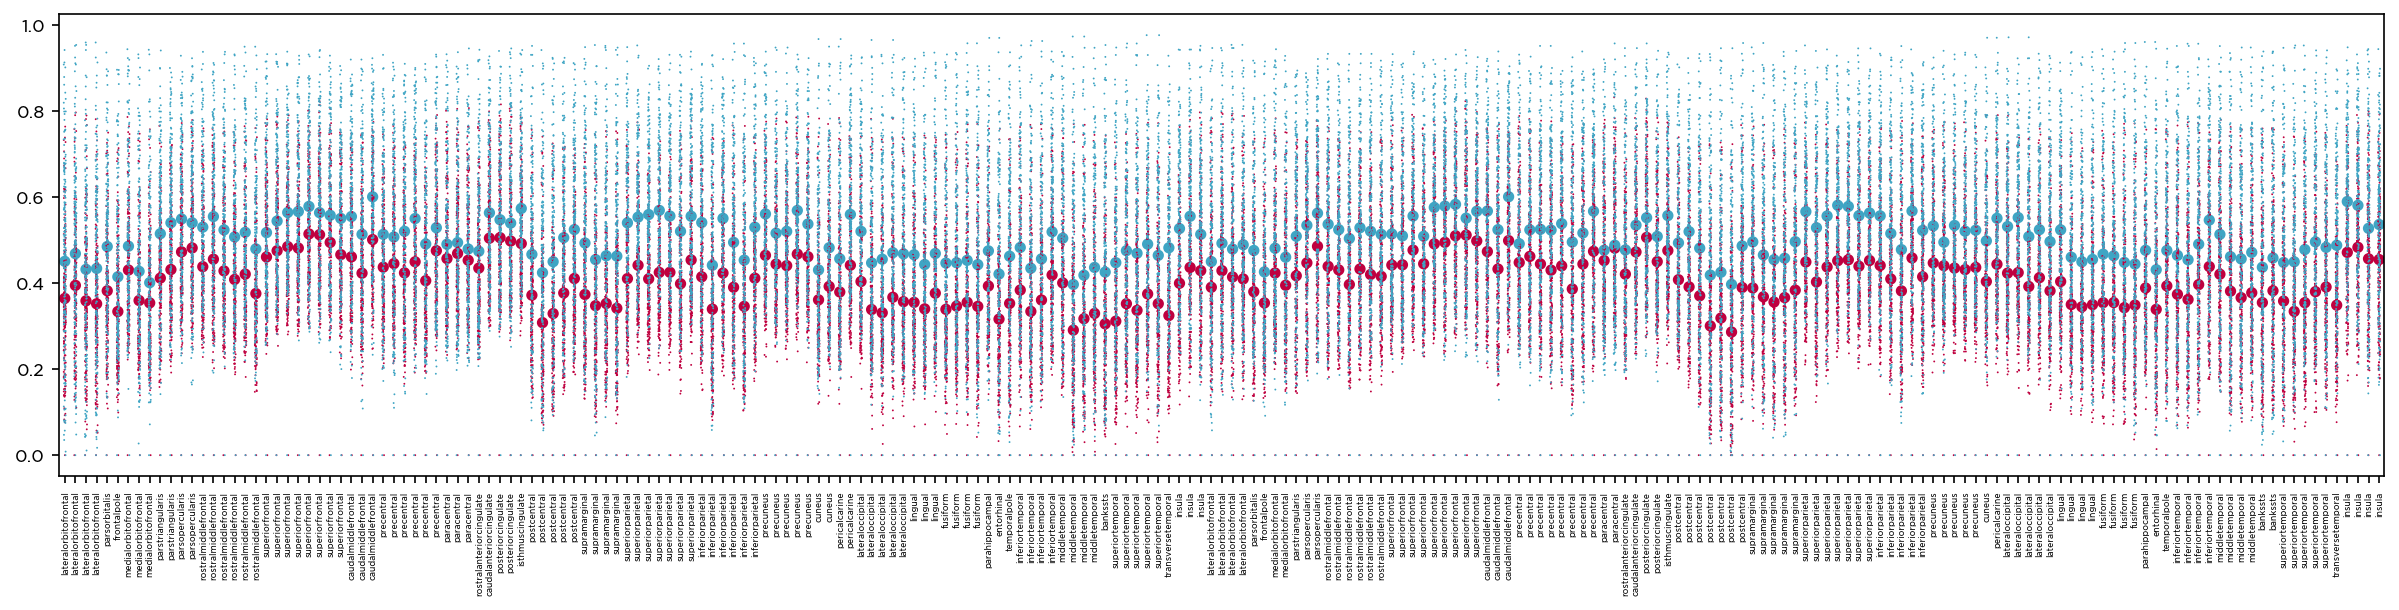

In [54]:
plt.figure(figsize=(20,4),dpi=150)
sns.pointplot(data=lognorm_ci,color=RED,label='Causal Influence',join=False,markers='.',errwidth=0.8)
sns.pointplot(data=lognorm_comm,color=BLUE,label='Communicability',join=False,markers='.',errwidth=0.8)

sns.stripplot(data=lognorm_ci,color=RED,label='Causal Influence',size=0.9)
sns.stripplot(data=lognorm_comm,color=BLUE,label='Communicability',size=0.9)
plt.xticks(ticks = [i for i,_ in enumerate(labels)],labels=labels,rotation=90,fontsize=4);

In [171]:
import statsmodels.api as sm
reg = sm.OLS(direct_influence.values.flatten(),
             lognorm_sc.flatten()).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                          4.906e+05
Date:                Fri, 14 Apr 2023   Prob (F-statistic):                        0.00
Time:                        18:02:51   Log-Likelihood:                          62573.
No. Observations:               47961   AIC:                                 -1.251e+05
Df Residuals:                   47960   BIC:                                 -1.251e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1994      0.002    700.456      0.000       1.196       1.203
==============================================================================
Omnibus:                    33159.807   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           616826.498
Skew:                           3.126   Prob(JB):                         0.00
Kurtosis:                      19.419   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

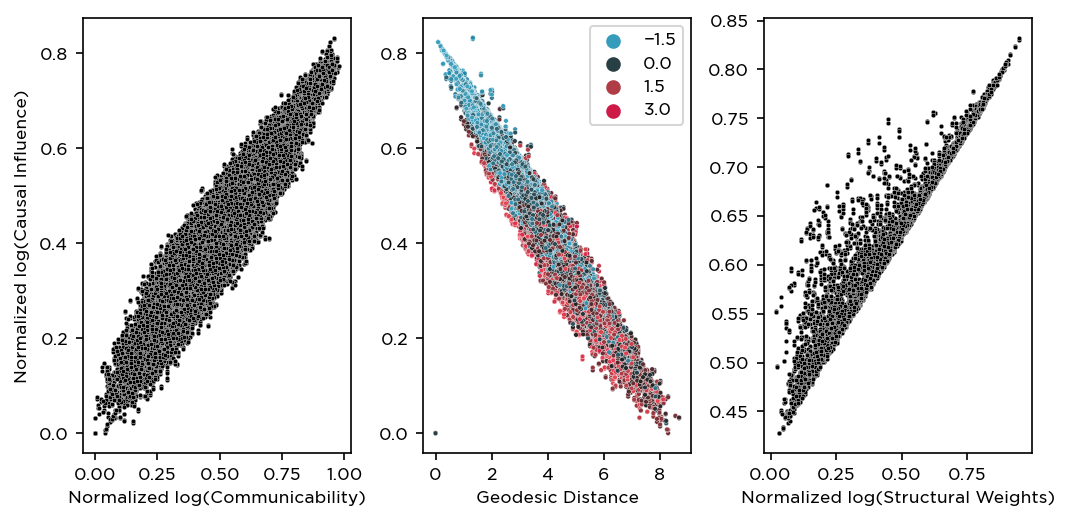

In [184]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
sns.scatterplot(x=lognorm_comm.flatten(),y=lognorm_ci.flatten(),color='k',ax=axes['A'],s=5)
sns.scatterplot(shortest_path_distance.flatten(),lognorm_ci.flatten(),ax=axes['B'],hue = difference.flatten(),
                palette=diverge_from_black, s=5)

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=lognorm_ci.flatten()[lognorm_sc.flatten()!=0],color='k',ax=axes['C'],s=5)
axes['A'].set_xlabel('Normalized log(Communicability)')
axes['A'].set_ylabel('Normalized log(Causal Influence)')
axes['B'].set_xlabel('Geodesic Distance')

axes['C'].set_xlabel('Normalized log(Structural Weights)')
fig.tight_layout(pad=1);
#plt.savefig(f"correlations.pdf",dpi=600,bbox_inches='tight')

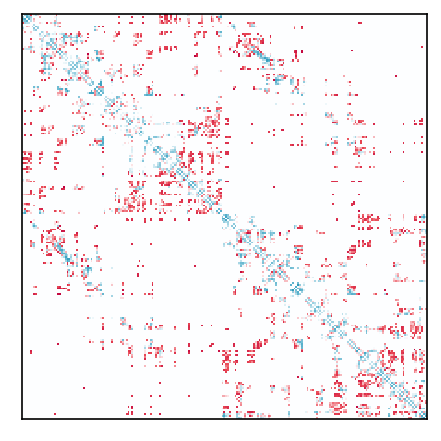

In [189]:
plt.figure(figsize=(3.5,3.5),dpi=150)
residuals = (reg.resid).reshape(len(lognorm_sc),len(lognorm_sc))
sns.heatmap(residuals,square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,cbar=False,linewidths=0, linecolor='k',center=0)
sns.despine(top=False, right=False, left=False, bottom=False)
